In [81]:
#chatgpt
from openai import OpenAI
client = OpenAI(api_key='Apikey')
#poner la apikey de openai para correr el codigo entero sin ningún inconveniente 
# manejo de datos
import os
import numpy as np
import pandas as pd
# manejo de strings
import re
# para la semilla de los graficos

import random 
# para las stopwords y la nube de palabras
from wordcloud import WordCloud,STOPWORDS

import nltk
nltk.download("punkt")
from nltk.tokenize import sent_tokenize, word_tokenize 
# Directorio donde se encuentran los archivos
directorio = r'C:\Users\Pc\Desktop\Redes\transciptor\trscripcion'
from nltk.corpus import stopwords
spanish_sw = set(stopwords.words('spanish'))

# para los graficos
import matplotlib.pyplot as plt
from plotnine import *
import matplotlib.colors as mcolors
import hashlib
# igraph
import igraph as ig

#Para el analisis de componentes principales
from sklearn.decomposition import PCA


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Las siguientes funciones sirven para decorar los gráficos de las redes asociadas a las palabras.


In [82]:
# adaptado de chat gpt 
def adjustcolor(color_name, alpha):
    # Convertir nombre de color a RGB
    rgb = mcolors.CSS4_COLORS.get(color_name)
    if rgb is None:
        raise ValueError(f"El color '{color_name}' no es válido.")
    
    # Convertir RGB a hexadecimal
    r, g, b = mcolors.to_rgb(rgb)
    hex_color = f'#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}'
    
    # Agregar canal alpha
    return f'{hex_color}{int(255 * alpha):02x}'

In [83]:
def get_color(integer, alpha=1.0):
    # Convert the integer to a unique string using hashing
    hash_object = hashlib.sha256(str(integer).encode())
    hex_dig = hash_object.hexdigest()
    # Convert the hexadecimal hash to RGB values
    r = int(hex_dig[:2], 16) % 256
    g = int(hex_dig[2:4], 16) % 256
    b = int(hex_dig[4:6], 16) % 256
    # Format RGB values into a color string
    color = "#{:02x}{:02x}{:02x}".format(r, g, b)
    # Return RGB values and alpha
    return (r / 255, g / 255, b / 255, alpha)
def get_colors_for_list(integer_list, alpha=1.0):
    colors = []
    for integer in integer_list:
        color = get_color(integer, alpha=alpha)
        colors.append(color)
    return colors

Se lee el archivo que se obtuvo de los subtítulos automáticos generados por YouTube de la lista de reproducción del caso 03 de la JEP. Además, se exporta el diccionario que contiene las palabras vacías.


In [84]:
# Definir la ruta del archivo de salida
archivo_salida = os.path.join(directorio, 'contenido_concatenado.txt')

# Abrir el archivo de salida en modo lectura
with open(archivo_salida, 'r', encoding='utf-8') as archivo:
    Caso_03 = archivo.read()
with open('stop_words_spanish.txt', 'r', encoding='utf-8') as archivo:
    stop_words_spanish = archivo.read()

In [85]:
stop_words_spanish=stop_words_spanish.split('\n')+list(spanish_sw)
stop_words_spanish=list(set(stop_words_spanish))
stop_words_spanish.extend(['eh', '','s']) # para ir agregando expresiones 

In [86]:
type(Caso_03) 

str

Se hace la limpieza del texto del caso 03 para su posterior tokenización por espacios.


In [87]:
# Eliminar múltiples espacios en blanco y convertir a minúsculas
Caso_03 = re.sub(r' +', ' ', Caso_03).lower()
# Eliminar caracteres no alfabéticos ni espacios en blanco utilizando una expresión regular
Caso_03 = re.sub(r'[^a-záéíóúüñ ]', '', Caso_03)
# cuidado con el orden
Caso_03=Caso_03.split(' ')

In [88]:
len(Caso_03) 

13847159

Se eliminan los tokens que están en las stop words.


In [89]:
tokens = []

for word in Caso_03:
    if word not in stop_words_spanish:
        tokens.append(word)


In [90]:
len(tokens) 

4671482

Se crea un DataFrame de Pandas con la lista de tokens y se calcula su frecuencia absoluta y se organiza de mayor a menor.

In [91]:
Tokens = pd.DataFrame(tokens, columns=['token'])

In [92]:
Frecuencias= (Tokens
              .groupby('token')
              .agg(frecuencia=("token","count")).reset_index()
              .sort_values(by=["frecuencia"],ascending=False)
             ).reset_index(drop=True)

In [93]:
Frecuencias[0:10]

,token,frecuencia
0,señor,64742
1,batallón,48247
2,comandante,37034
3,hechos,26184
4,doctor,24964
5,magistrado,24910
6,información,24267
7,sé,23861
8,operaciones,22811
9,brigada,21726


Se crea un diagrama con las 10 palabras que más aparecen a lo largo del caso 03.

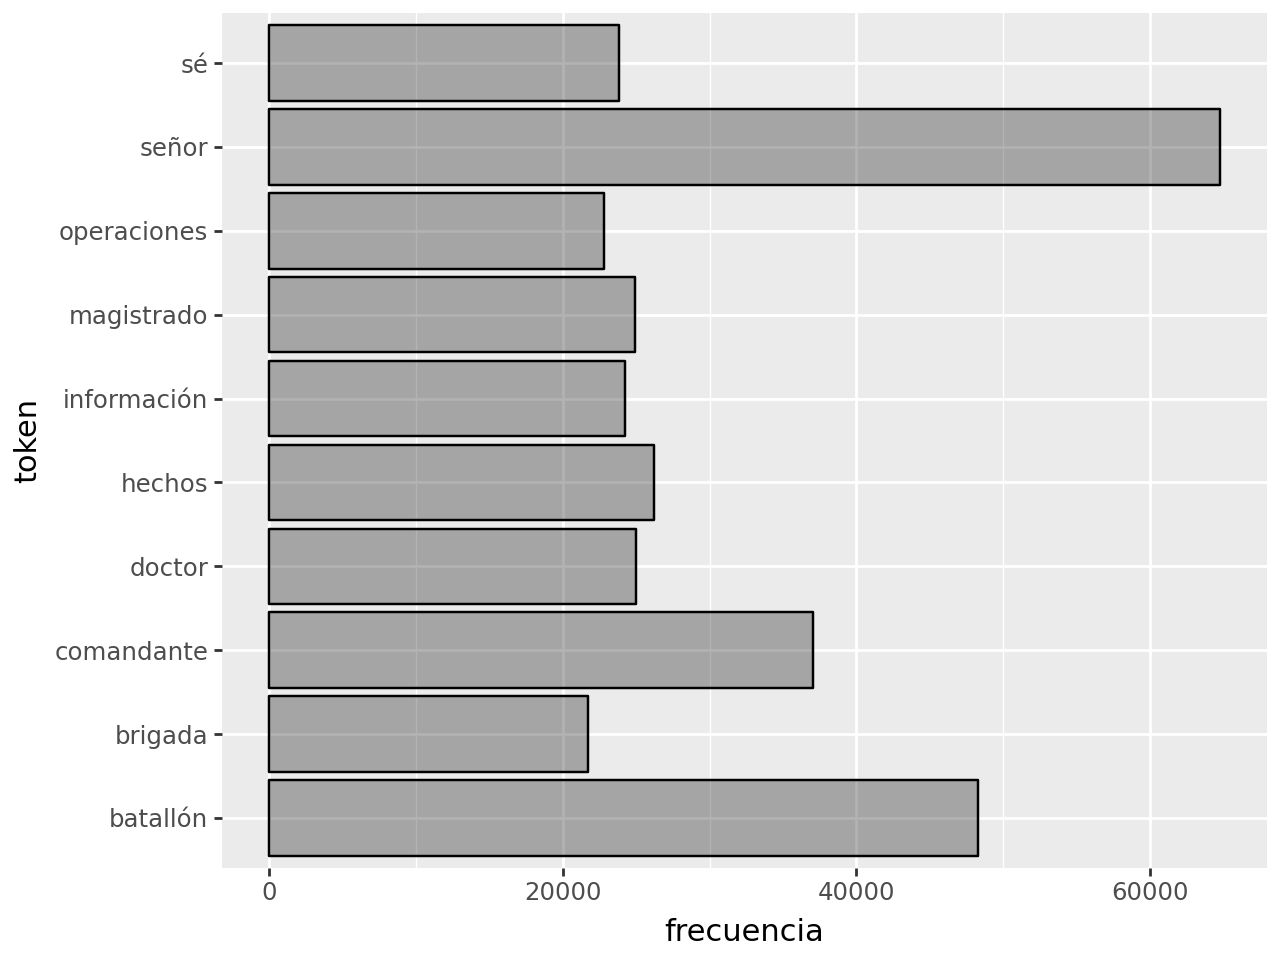

In [94]:

# Crear el histograma usando ggplot
histograma = (
    ggplot(Frecuencias[0:10], aes(x='token', y='frecuencia')) +
    geom_bar(stat='identity', color='black', fill=adjustcolor('black',0.3)) +
    coord_flip()
)

# Mostrar el histograma
histograma.show()

Las 10 palabras con una frecuencia absoluta mayor están relacionadas con figuras de autoridad, instituciones militares y términos legales, dando indicios de la posible importancia que tienen estos temas a lo largo de toda la lista de reproducción asociada a este caso en la JEP.


In [95]:
wordcloud = WordCloud(
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(" ".join(tokens))

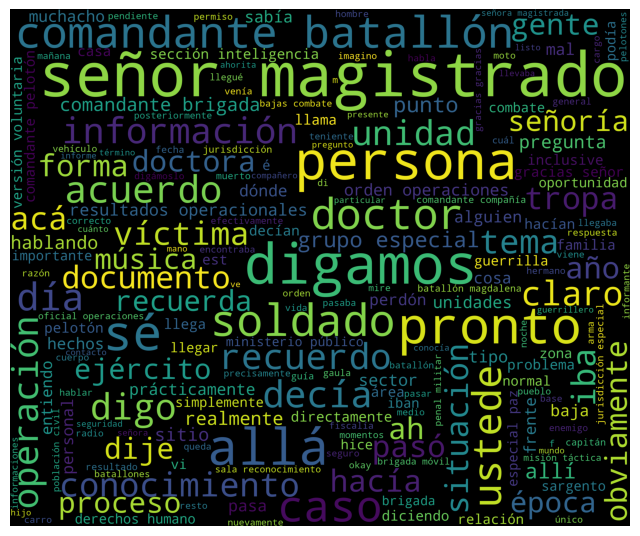

In [96]:
plt.figure(1,figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Al momento de analizar la nube de palabras generada por el texto extraído del caso 03, se puede observar que hay más términos relacionados con temas como figuras de autoridad, instituciones militares y términos legales, dando mayores indicios de la importancia de estos temas al momento de desarrollar estos casos.



## Analisis de Sentimiento

Se importan los diccionarios con las palabras negativas y positivas en español.


In [97]:
with open('negative_words_es.txt', 'r', encoding='utf-8') as archivo:
    negative_words = archivo.read()
with open('positive_words_es.txt', 'r', encoding='utf-8') as archivo:
    positive_words = archivo.read()

In [98]:
negative_words=negative_words.split('\n')
positive_words=positive_words.split('\n')

Se crea un DataFrame de Pandas con las palabras positivas y negativas. Luego se realiza un left join con el DataFrame de frecuencias previamente creado para observar cuántas veces aparecen estas palabras a lo largo del caso 03.


In [99]:
negative_words = pd.DataFrame(negative_words, columns=['negative_words'])
positive_words = pd.DataFrame(positive_words, columns=['positive_words'])

In [100]:
Caso_03_nw=(negative_words
.merge(Frecuencias, left_on='negative_words', right_on='token', how='left')
.sort_values(by='frecuencia',ascending=[False]).reset_index(drop=True))

Caso_03_nw=Caso_03_nw.dropna(axis=0, how='any') # para que no nos de problemas eliminamos los NA

In [101]:
Caso_03_pw=(positive_words
.merge(Frecuencias, left_on='positive_words', right_on='token', how='left')
.sort_values(by='frecuencia',ascending=[False]).reset_index(drop=True))

Caso_03_pw=Caso_03_pw.dropna(axis=0, how='any') # para que no nos de problemas eliminamos los NA

In [102]:
Caso_03_nw[1:10]

,negative_words,token,frecuencia
1,situación,situación,9827.0
2,baja,baja,6139.0
3,sitio,sitio,5754.0
4,víctima,víctima,4829.0
5,mal,mal,4764.0
6,muerte,muerte,4374.0
7,responsabilidad,responsabilidad,3835.0
8,mire,mire,3429.0
9,táctica,táctica,3083.0


In [103]:
Frecuencias

,token,frecuencia
0,señor,64742
1,batallón,48247
2,comandante,37034
3,hechos,26184
4,doctor,24964
...,...,...
88024,hernand,1
88025,pinuel,1
88026,pintón,1
88027,hernanda,1


In [104]:
(sum(Caso_03_nw['frecuencia'])/sum(Frecuencias['frecuencia']) )*100

4.382784735122602

Al observar las palabras negativas con mayor frecuencia, se puede notar que posiblemente se estén abordando temas trágicos relacionados con las pérdidas en el conflicto armado colombiano. Esto era de esperarse dada la naturaleza del texto que estamos analizando. Además, se puede observar que alrededor del 4.4% de todas las palabras en la lista de reproducción tienen alguna connotación negativa según nuestro diccionario.


In [105]:
Caso_03_pw[1:10]

,positive_words,token,frecuencia
1,pronto,pronto,19070.0
2,gracias,gracias,17668.0
3,inteligencia,inteligencia,15264.0
4,acuerdo,acuerdo,15109.0
5,unidad,unidad,12762.0
6,claro,claro,9803.0
7,general,general,9233.0
8,diligencia,diligencia,8377.0
9,favor,favor,7770.0


In [106]:
(sum(Caso_03_pw['frecuencia'])/sum(Frecuencias['frecuencia']) )*100

7.825696427814556

Al observar las palabras positivas con más frecuencia, se puede notar términos como "gracias", "acuerdo" y "unidad", que pueden denotar un sentimiento conciliador dado al acuerdo de paz realizado por el gobierno de Juan Manuel Santos. También cabe resaltar que la proporción de palabras positivas es casi el doble que las negativas, siendo algo a tener muy en consideración debido a la naturaleza del caso 03.

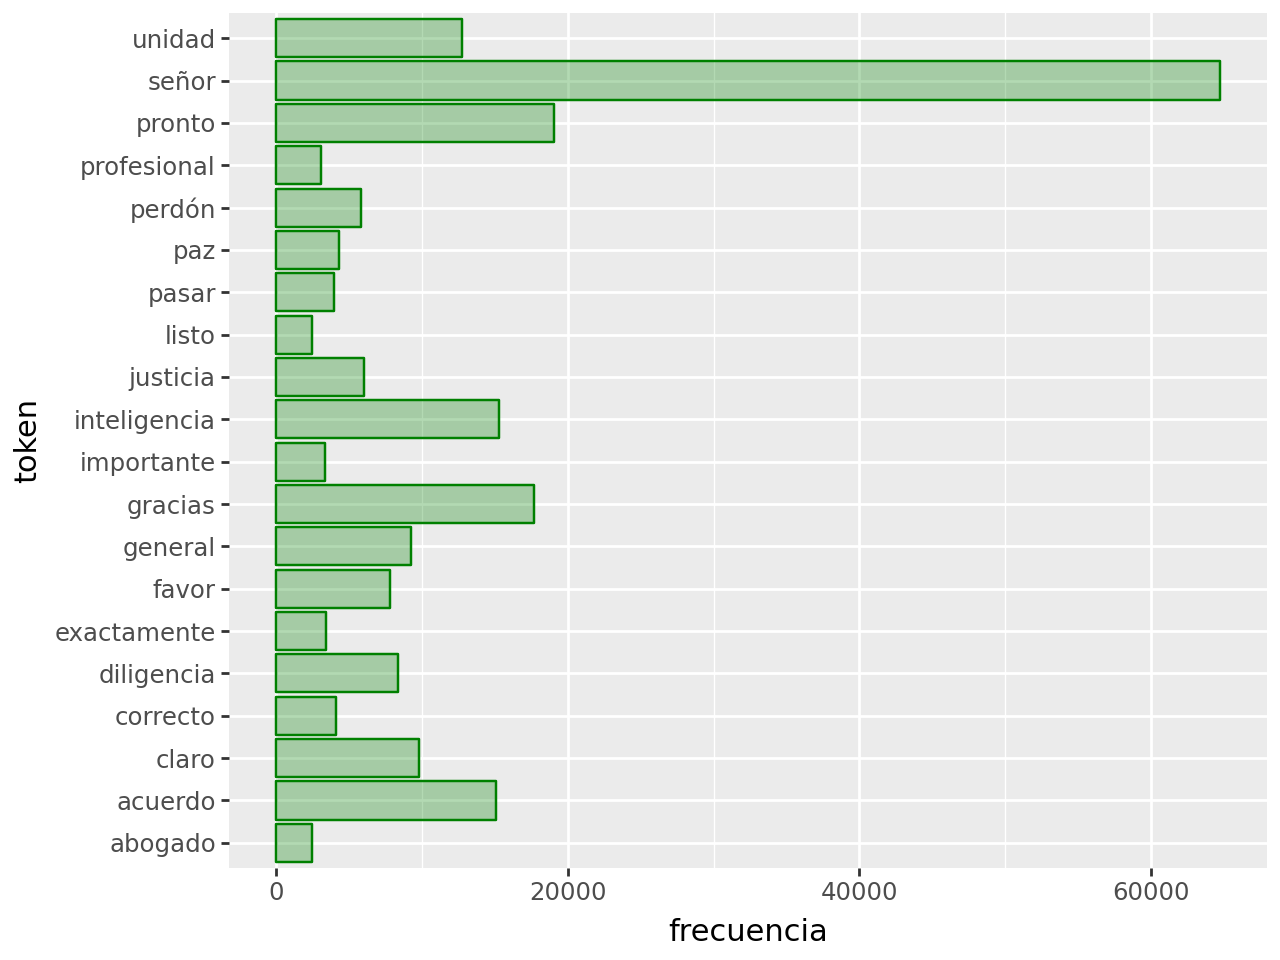

In [107]:
# Crear el histograma usando ggplot
histograma = (
    ggplot(Caso_03_pw[0:20], aes(x='token', y='frecuencia')) +
    geom_bar(stat='identity', color='green', fill=adjustcolor('green',0.3)) +
    coord_flip()
)

# Mostrar el histograma
histograma.show()

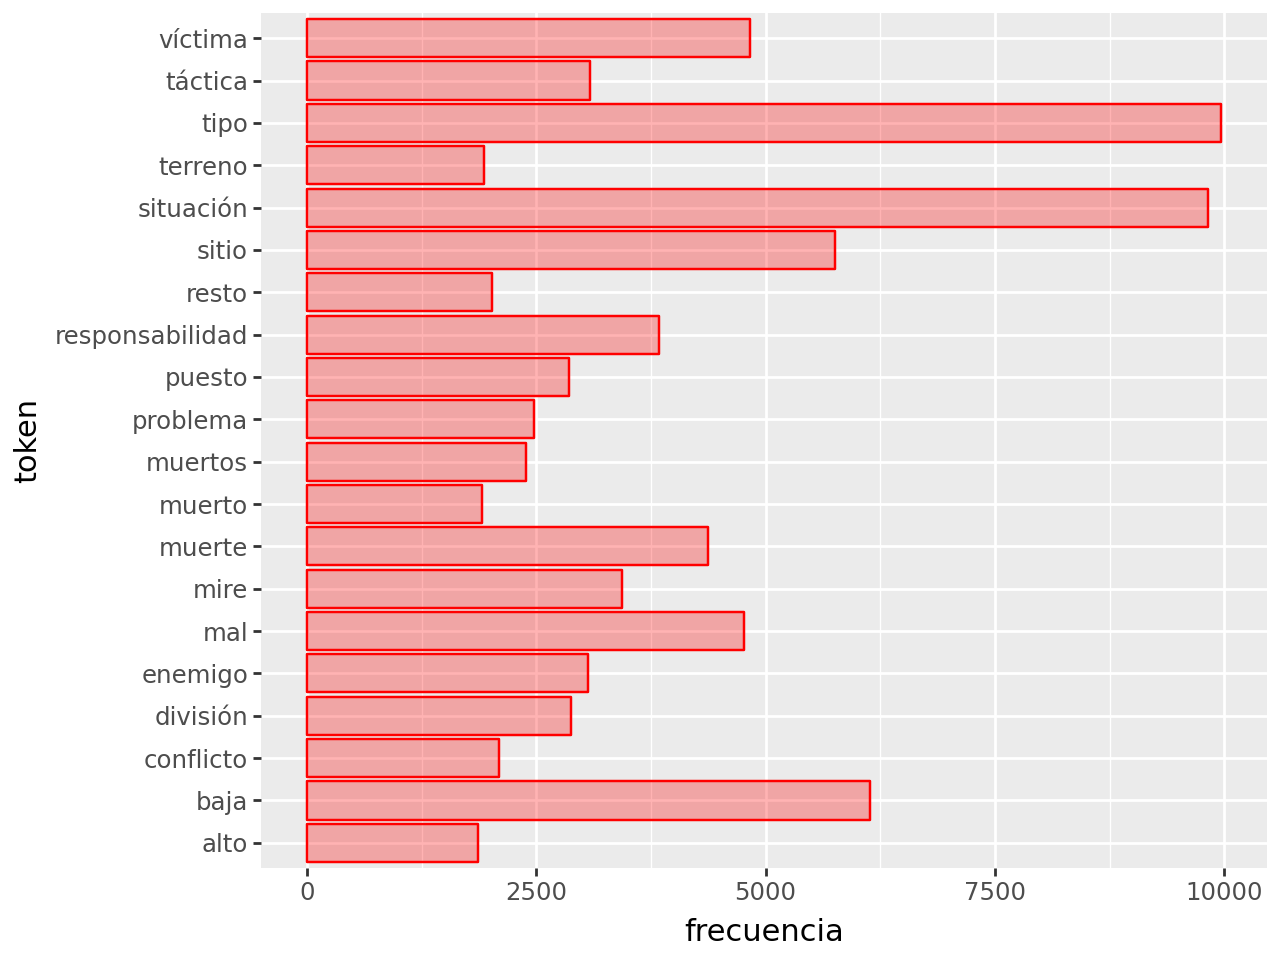

In [108]:
# Crear el histograma usando ggplot
histograma = (
    ggplot(Caso_03_nw[0:20], aes(x='token', y='frecuencia')) +
    geom_bar(stat='identity', color='red',fill=adjustcolor('red',0.3)) +
    coord_flip()
)

# Mostrar el histograma
histograma.show()

## Bigramas

Para generar los bigramas, se toman todos los tokens y se añade el token siguiente. Posteriormente, se une con un espacio.

In [109]:
Bigrama=[' '.join(tokens[i:i+2]) for i in range(0, len(tokens)-1)]

Se convierte la lista creada con los tokens concatenados en un DataFrame de Pandas. Para una mayor cohesión en este caso, se eliminan los acentos de los bigramas y se calcula su frecuencia.

In [110]:

Bigrama=pd.DataFrame(Bigrama, columns=['Bigrama'])


In [111]:
Bigrama

,Bigrama
0,catalina díaz
1,díaz gómez
2,gómez magistrada
3,magistrada sala
4,sala reconocimiento
...,...
4671476,incluyen fuerzas
4671477,fuerzas policía
4671478,policía nacional
4671479,nacional efecto


In [112]:
Bigrama['Bigrama'] = (Bigrama.Bigrama
                      .str.lower()
                      .str.replace(" +", " ", regex=True)
                      .str.replace('á', 'a', regex=True)
                      .str.replace('é', 'e', regex=True)
                      .str.replace('í', 'i', regex=True)
                      .str.replace('ó', 'o', regex=True)
                      .str.replace('ú', 'u', regex=True)
                      .str.replace('ü', 'u', regex=True)
                      .str.strip()
                      )


In [113]:
Bigrama

,Bigrama
0,catalina diaz
1,diaz gomez
2,gomez magistrada
3,magistrada sala
4,sala reconocimiento
...,...
4671476,incluyen fuerzas
4671477,fuerzas policia
4671478,policia nacional
4671479,nacional efecto


In [114]:
FrecuenciaBigrama=( Bigrama.groupby('Bigrama')
              .agg(frecuencia=("Bigrama","count")).reset_index()
              .sort_values(by=["frecuencia"],ascending=False)
             ).reset_index(drop=True)
              

In [115]:
FrecuenciaBigrama[0:10]

,Bigrama,frecuencia
0,señor magistrado,19537
1,comandante batallon,9549
2,grupo especial,4076
3,comandante brigada,3867
4,resultados operacionales,3612
5,orden operaciones,3486
6,seccion inteligencia,3060
7,version voluntaria,3054
8,comandante peloton,3051
9,gracias señor,3007


Ahora se necesita definir un umbral para crear la red asociada con los bigramas generados a partir del caso 03. Para definir este umbral, se utilizará el cuantil de las frecuencias de los bigramas, ya que se desea un número específico de palabras para evitar exceder la capacidad computacional disponible. De esta manera, podremos observar cuántas veces se repiten los términos seleccionados.

Si se desea, se puede reducir el umbral para obtener más bigramas para analizar en la red. Sin embargo, en este caso se busca tener aproximadamente 200 nodos en la red. Por lo tanto, para encontrar el cuantil que nos dé al menos 200 bigramas, podemos expresarlo como:

$$
\alpha = 1 - \frac{200}{n}
$$

Donde $ \alpha $ representa el cuantil y $ n $ es el número total de bigramas.


In [116]:
alpha=1-200/len(FrecuenciaBigrama['Bigrama']) # para ajustar el umbral

In [117]:
alpha

0.9999093449903589

In [118]:
 np.percentile(FrecuenciaBigrama['frecuencia'], q=[0.999909344990358])

array([1.])

In [119]:
FrecuenciaBigrama=FrecuenciaBigrama[FrecuenciaBigrama['frecuencia']>400]

Con una función lambda y la función apply, se toman los bigramas restantes para generar la matriz de aristas. Dado que no se analiza una transcripción, pueden haber palabras repetidas, por lo tanto, se eliminan estos bigramas.

In [120]:
# Dividir cada elemento de la columna 'Bigrama' en bigramas individuales
bigramas_divididos = FrecuenciaBigrama['Bigrama'].apply(lambda x: x.split())

# Crear listas separadas para el primer y segundo elemento de cada bigrama
primer_elemento = []
segundo_elemento = []

for bigrama in bigramas_divididos:
    if len(bigrama) == 2 and bigrama[0]!=bigrama[1]:
        primer_elemento.append(bigrama[0])
        segundo_elemento.append(bigrama[1])
    else:
        print('Bigrama no incluido: '+ str(bigrama))



Bigrama no incluido: ['gracias', 'gracias']
Bigrama no incluido: ['señor', 'señor']
Bigrama no incluido: ['batallon', 'batallon']
Bigrama no incluido: ['se', 'se']
Bigrama no incluido: ['dia', 'dia']
Bigrama no incluido: ['dias', 'dias']
Bigrama no incluido: ['brigada', 'brigada']
Bigrama no incluido: ['recuerdo', 'recuerdo']
Bigrama no incluido: ['peloton', 'peloton']
Bigrama no incluido: ['comandante', 'comandante']
Bigrama no incluido: ['compañia', 'compañia']
Bigrama no incluido: ['soldado', 'soldado']
Bigrama no incluido: ['informacion', 'informacion']
Bigrama no incluido: ['acuerdo', 'acuerdo']
Bigrama no incluido: ['caso', 'caso']
Bigrama no incluido: ['soldados', 'soldados']
Bigrama no incluido: ['año', 'año']
Bigrama no incluido: ['hechos', 'hechos']
Bigrama no incluido: ['persona', 'persona']
Bigrama no incluido: ['pronto', 'pronto']
Bigrama no incluido: ['coronel', 'coronel']
Bigrama no incluido: ['años', 'años']
Bigrama no incluido: ['alla', 'alla']
Bigrama no incluido: ['i

In [121]:
Bigrama = pd.DataFrame({'V1': primer_elemento, 'V2': segundo_elemento})


In [122]:
Bigrama

,V1,V2
0,señor,magistrado
1,comandante,batallon
2,grupo,especial
3,comandante,brigada
4,resultados,operacionales
...,...,...
211,identificado,cedula
212,compañia,c
213,general,montoya
214,compañia,comandante


Ya que se está trabajando con igraph, se necesita generar un identificador único para cada nodo. Este identificador debe estar entre 0 y el tamaño del nodo. Para esto, se concatenan las dos columnas de la matriz de vértices y se extraen sus valores únicos. A cada valor único se le asigna un número que será su respectivo identificador. Luego, se realizan dos left join para asignarle su respectivo identificador a la matriz de aristas y obtener el DataFrame que se le pasará a igraph para que cree el respectivo grafo asociado a los bigramas que surgieron del caso 03.

In [123]:
Concatenado=primer_elemento+ segundo_elemento

In [124]:
# Obtener valores únicos de la lista Concatenado y convertirlos en un DataFrame
df_tokens = pd.DataFrame({'token': list(set(Concatenado))})

# Generar identificadores únicos
df_tokens['Identificador'] = range(len(df_tokens))

# Establecer 'token' como índice
df_tokens.set_index('Identificador', inplace=True)

df_tokens.reset_index(inplace=True)
df_tokens

,Identificador,token
0,0,ilegitimamente
1,1,mando
2,2,judicial
3,3,resultados
4,4,anexo
...,...,...
228,228,voluntarias
229,229,delincuencia
230,230,sali
231,231,acuerdo


In [125]:
Identificados=Bigrama.merge(df_tokens,left_on='V1',right_on="token",how="left").merge(df_tokens,left_on='V2',right_on="token",how="left")
Identificados

,V1,V2,Identificador_x,token_x,Identificador_y,token_y
0,señor,magistrado,71,señor,205,magistrado
1,comandante,batallon,9,comandante,168,batallon
2,grupo,especial,5,grupo,80,especial
3,comandante,brigada,9,comandante,152,brigada
4,resultados,operacionales,3,resultados,213,operacionales
...,...,...,...,...,...,...
211,identificado,cedula,212,identificado,29,cedula
212,compañia,c,193,compañia,199,c
213,general,montoya,100,general,222,montoya
214,compañia,comandante,193,compañia,9,comandante


In [126]:
Aristas=Identificados[['Identificador_x', 'Identificador_y']]
Aristas

,Identificador_x,Identificador_y
0,71,205
1,9,168
2,5,80
3,9,152
4,3,213
...,...,...
211,212,29
212,193,199
213,100,222
214,193,9


Se crea el objeto igraph con la matriz de aristas que contiene los identificadores únicos de los nodos. Además, a cada nodo se le asigna el nombre correspondiente a la palabra asociada a este y se define el color de los grafos como rojo.


In [127]:
g = ig.Graph.DataFrame(Aristas, directed=False) 
g.vs['name']=df_tokens['token']
g.vs['color']=adjustcolor('red',0.4)

In [128]:
cg=g.subgraph(vertices=g.connected_components()[0])

In [129]:
random.seed(123)
lg=cg.layout_graphopt()
l=g.layout_graphopt()

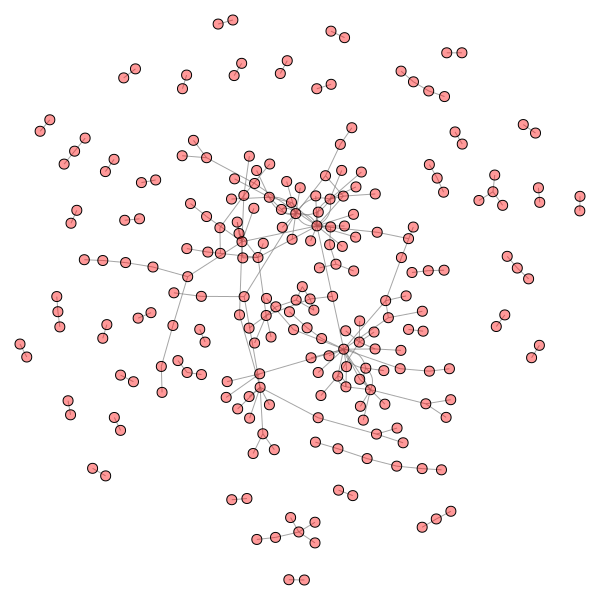

In [131]:
vertex_labels = {v.index: str(v.index) for v in cg.vs}

# Grafica el grafo con las etiquetas
ig.plot(g,
        target="bigraph.png",
        background=None,
        edge_color=adjustcolor('gray', 0.7),
        vertex_label_cex=1,
        vertex_label_color=adjustcolor("black", 0.6),
        vertex_label_dist=0.5,
        vertex_size=10,
        vertex_label_degree=2,
        layout=l)

Se calcula la centralidad por cercanía, la centralidad propia y la centralidad por intermediación de todos los vértices. Además, se intenta hacer una componente principal que resuma todas estas medidas y así determinar el grado de importancia de todos los nodos. Dado que ninguna componente tiene el mismo signo, no se puede utilizar para ordenarlas de mayor a menor, ya que no es un factor de tamaño.
or lo tanto esta no puede ser interpretada como un factor de tamñao

In [132]:

closeness=g.closeness()
betweenness=g.betweenness(directed=False)
eigenvector=g.eigenvector_centrality(directed=False)

# Crear un DataFrame para almacenar las medidas de centralidad
df_centralidad = pd.DataFrame({'Closeness': closeness,
                               'Betweenness': betweenness,
                               'Eigenvector': eigenvector})

# Realizar PCA en las medidas de centralidad
pca = PCA(n_components=3)
pca.fit(df_centralidad.transpose())

# Obtener las componentes principales
componentes_principales = pca.components_


In [133]:
df_centralidad = pd.DataFrame({'Closeness': closeness,
                               'Betweenness': betweenness,
                               'Eigenvector': eigenvector,
                              'Componentes Principales':componentes_principales[0]})
df_centralidad['indice'] = df_centralidad.index
df=df_centralidad.merge(df_tokens,left_on="indice",right_on="Identificador",how="right")
df = df.drop('indice', axis=1)

In [134]:
df

,Closeness,Betweenness,Eigenvector,Componentes Principales,Identificador,token
0,0.159456,1.0,1.141716e-03,0.000105,0,ilegitimamente
1,1.000000,0.0,0.000000e+00,-0.000057,1,mando
2,1.000000,0.0,0.000000e+00,-0.000057,2,judicial
3,1.000000,0.0,0.000000e+00,-0.000057,3,resultados
4,0.222031,0.0,3.049320e-02,-0.000014,4,anexo
...,...,...,...,...,...,...
228,1.000000,0.0,0.000000e+00,-0.000057,228,voluntarias
229,1.000000,0.0,3.218449e-18,-0.000057,229,delincuencia
230,0.211475,0.0,2.537832e-02,-0.000014,230,sali
231,0.168407,0.0,3.869297e-03,-0.000010,231,acuerdo


Se calcula la distancia media, el grado medio, la desviación del grado, el número de clanes, la densidad, la transitividad y la asortatividad del grafo.


In [136]:
# Calcular las medidas para el grafo
distancia_media = g.average_path_length()
grado_medio = sum(g.degree()) / len(g.vs)
grado_desviacion = np.std(g.degree())
numero_clan = len(g.largest_cliques()[0])
densidad = g.density()
transitividad = g.transitivity_undirected()
asortatividad = g.assortativity_degree()

# Imprimir los resultados
print("Distancia media:", distancia_media)
print("Grado medio:", grado_medio)
print("Grado desviación:", grado_desviacion)
print("Número clan:", numero_clan)
print("Densidad:", densidad)
print("Transitividad:", transitividad)
print("Asortatividad:", asortatividad)


Distancia media: 4.885245901639344
Grado medio: 1.854077253218884
Grado desviación: 2.177763772732463
Número clan: 3
Densidad: 0.007991712298357259
Transitividad: 0.040268456375838924
Asortatividad: 0.0644377858908607


Se puede observar que la distancia geodésica promedio es alrededor de 4. Esto quiere decir que, en promedio, se necesitan 4 aristas para llegar de una palabra a otra por medio de las aristas.

El grado medio es de 1.85. Esto quiere decir que el número de aristas incidentes por palabra en promedio es de 1.85, es decir, que en promedio, las palabras de la red están conectadas con 1.85 palabras.

La desviación estándar del grado es de 2.18. Al ser mayor que la media, refleja que los datos son muy variables y que el grado cambia mucho entre ellos.

El número de clan es de 3. Esto quiere decir que el subgrafo que son completos (todas las palabras están conectadas entre sí) es 3, lo que indica una conectividad baja de la red.

La transitividad global del grafo, que se calcula como el número de tríadas cerradas sobre el número de tríadas (siendo una tríada cerrada cualquier subgrafo de 3 palabras completo), ayuda a ver que, por lo general, las palabras adyacentes entre sí no suelen ser adyacentes a otra palabra en común.

La asortatividad es un indicador de homofilia, es decir, qué tan parecidos son los grados de las palabras que están conectadas. Se puede observar, por su bajo valor, que no son muy parecidos.


Con la componente gigante del grafo, se procede a hacer clustering. Se analiza cuál de los metodos de agrupamiento tiene una mayor modularidad y mide qué tan buena es la división o qué tan separados están los diferentes tipos de vértices entre sí. por lo tanto se escoge la particion que surge del metodo  Edge-betweenness.


In [137]:
random.seed(12)
eb=cg.community_edge_betweenness()
im=cg.community_infomap()
lp=cg.community_label_propagation()
le=cg.community_leading_eigenvector()

In [138]:
eb_clustering = eb.as_clustering()
print("Modularidad de community_edge_betweenness:", round(eb_clustering.modularity))
print("Modularidad de community_infomap:", round(im.modularity, 3))
print("Modularidad de community_label_propagation:", round(lp.modularity, 3))
print("Modularidad de community_leading_eigenvector:", round(le.modularity, 3))

Modularidad de community_edge_betweenness: 1
Modularidad de community_infomap: 0.661
Modularidad de community_label_propagation: 0.683
Modularidad de community_leading_eigenvector: 0.709


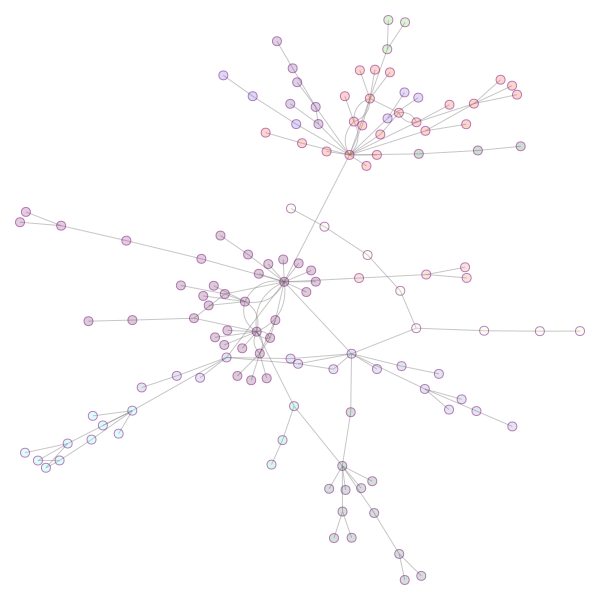

In [156]:
random.seed(3)
ig.plot(cg,
        target="bigraphcluster.png",
        edge_color =adjustcolor('gray',0.45),
        vertex_frame_color =adjustcolor('purple',0.5),
        vertex_color= get_colors_for_list(eb_clustering.membership, alpha=0.2),
        vertex_size = 9, #toca ajustar un tamaño minimo porque algunos son
        # pequeño
       )

In [157]:
Componente_Gigante=df.query('Identificador in @ g.connected_components()[0]')
Componente_Gigante['edge_betweenness']=eb.as_clustering().membership
Componente_Gigante['infomap']=im.membership
Componente_Gigante['label_propagation']=lp.membership
Componente_Gigante['leading_eigenvector']=le.membership

C:\Users\Pc\AppData\Local\Temp\ipykernel_4648\2612356879.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Pc\AppData\Local\Temp\ipykernel_4648\2612356879.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Pc\AppData\Local\Temp\ipykernel_4648\2612356879.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

In [158]:
set(eb.as_clustering().membership)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}

Se puede observar que hay 14 clústeres. En cada clúster, se organizan las palabras en orden descendente teniendo en cuenta sus medidas de centralidad. Posteriormente, se utiliza GPT-4 para determinar cuál es el tema que más relaciona estas palabras, lo que permite identificar los temas más importantes que se trataron en el caso 03.


In [159]:
# Inicializar el diccionario
diccionario = {}

# Iterar sobre los clusters
for c in set(eb.as_clustering().membership):
    # Obtener los tokens ordenados según los criterios
    tokens_ordenados = Componente_Gigante.query('edge_betweenness==@c').sort_values(by=['Closeness','Betweenness','Eigenvector'],ascending=[False,False,False]).reset_index(drop=True)['token']
    
    # Concatenar los tokens en una cadena
    tema = ' '.join(tokens_ordenados)
    
    # Agregar al diccionario
    diccionario['cluster '+str(c)] = tema

# Mostrar el diccionario resultante
print(diccionario)

{'cluster 0': 'combate muertes bajas muertos baja muerte presentadas legitimamente ilegitimamente ilegitimas', 'cluster 1': 'operaciones inteligencia seccion oficial jefe orden desarrollo ordenes informacion anexo publico batalla dia operacion pago ministerio', 'cluster 2': 'jurisdiccion especial paz grupo', 'cluster 3': 'batallon comandante brigada comando comandantes trasladado contraguerrillas panza comante contraguerrilla pigoanza magdalena guerrilla compañia ejercito peloton directamente abrigada ejecutivo division novena cuarta movil operativo sali nacional c b instruccion nivel', 'cluster 4': 'coronel teniente torres pinto suarez escalante', 'cluster 5': 'señor gracias recuerdo dias magistrado preguntas hechos claro procurador pregunta compareciente doctor nombre muchisimas doctora dios exactamente honorable permiso sitio recuerda completo acuerdo', 'cluster 6': 'militares fuerzas unidades especiales tacticas grupos misiones armados', 'cluster 7': 'infanteria numero cedula ident

In [160]:
PromptInicio = ['Utilizando el diccionario de clusters  de palabras proporcionado a continuación, extrae el tema o tópico que más se relacione con cada cluster:Ten en cuenta que las palabras fueron obtenidas mediante un método de agrupamiento de una red asociada a bigramas sacados de un texto, también ten en cuenta que las palabras vienen de mayor a menor importancia' 
, '[Inicio  diccionario]']

PromptFinal = ['[Fin  diccionario]', 'Al momento de devolver los datos contesta con el siguiente formato: Numerodecluster:[dato] TemaoTopicoPrincipal:[dato] Solo contesta con el formato suministrado.' ]

In [161]:
request=" ".join(PromptInicio)+str(diccionario)+" ".join(PromptFinal)

In [162]:
request

"Utilizando el diccionario de clusters  de palabras proporcionado a continuación, extrae el tema o tópico que más se relacione con cada cluster:Ten en cuenta que las palabras fueron obtenidas mediante un método de agrupamiento de una red asociada a bigramas sacados de un texto, también ten en cuenta que las palabras vienen de mayor a menor importancia [Inicio  diccionario]{'cluster 0': 'combate muertes bajas muertos baja muerte presentadas legitimamente ilegitimamente ilegitimas', 'cluster 1': 'operaciones inteligencia seccion oficial jefe orden desarrollo ordenes informacion anexo publico batalla dia operacion pago ministerio', 'cluster 2': 'jurisdiccion especial paz grupo', 'cluster 3': 'batallon comandante brigada comando comandantes trasladado contraguerrillas panza comante contraguerrilla pigoanza magdalena guerrilla compañia ejercito peloton directamente abrigada ejecutivo division novena cuarta movil operativo sali nacional c b instruccion nivel', 'cluster 4': 'coronel teniente 

In [167]:

    request = request
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": request,
            }
        ],
        model="gpt-4-1106-preview",
        max_tokens=2000,  # Incrementa el número de tokens permitidos
        temperature=0.7,  # Elimina la "creatividad" para obtener respuestas precisas
        top_p=1,  # Ajusta la probabilidad máxima para asegurar que la respuesta sea precisa
    )
    respuesta = chat_completion.choices[0].message.content

In [168]:
print(respuesta)

Numerodecluster:0 TemaoTopicoPrincipal:Conflictos y bajas militares
Numerodecluster:1 TemaoTopicoPrincipal:Operaciones militares y estructura de mando
Numerodecluster:2 TemaoTopicoPrincipal:Jurisdicción y procesos de paz
Numerodecluster:3 TemaoTopicoPrincipal:Estructura y organización militar
Numerodecluster:4 TemaoTopicoPrincipal:Oficiales militares
Numerodecluster:5 TemaoTopicoPrincipal:Procedimientos judiciales y testimonios
Numerodecluster:6 TemaoTopicoPrincipal:Fuerzas especiales y tácticas militares
Numerodecluster:7 TemaoTopicoPrincipal:Identificación militar y registro personal
Numerodecluster:8 TemaoTopicoPrincipal:Sistema penal y justicia militar
Numerodecluster:9 TemaoTopicoPrincipal:Procesos voluntarios y diligencias legales
Numerodecluster:10 TemaoTopicoPrincipal:Referencias personales o geográficas
Numerodecluster:11 TemaoTopicoPrincipal:Figuras legales y judiciales
Numerodecluster:12 TemaoTopicoPrincipal:Alto mando militar
Numerodecluster:13 TemaoTopicoPrincipal:Tácticas

# Skip Grama

Para generar los skipgramas, se toman todos los tokens y se añade el token siguiente al token que precede. Posteriormente, se unen con un espacio. Luego, todos los procedimientos son los mismos que los realizados con el bigrama.

In [208]:
SplitGrama=[' '.join([tokens[i], tokens[i+2]]) for i in range(0, len(tokens)-2)]

In [209]:
SplitGrama=pd.DataFrame(SplitGrama, columns=['SplitGrama'])


In [171]:
FrecuenciaSplitGrama=( SplitGrama.groupby('SplitGrama')
              .agg(frecuencia=("SplitGrama","count")).reset_index()
              .sort_values(by=["frecuencia"],ascending=False)
             ).reset_index(drop=True)
              

In [172]:
FrecuenciaSplitGrama

,SplitGrama,frecuencia
0,comandante comandante,2504
1,batallón batallón,2349
2,jurisdicción paz,2240
3,señor señor,2103
4,justicia militar,1407
...,...,...
2626004,estratégicos batallones,1
2626005,estratégicos bases,1
2626006,estratégicos b,1
2626007,estratégicos aproximación,1


In [173]:
1-200/len(FrecuenciaSplitGrama['frecuencia']) # para ajustar el umbral

0.9999238387987246

In [174]:
np.percentile(FrecuenciaSplitGrama['frecuencia'], q=[25, 50, 75, 90, 95, 0.9999239143915167*100])

array([  1.        ,   1.        ,   1.        ,   2.        ,
         4.        , 257.19858344])

In [175]:
FrecuenciaSplitGrama=FrecuenciaSplitGrama[FrecuenciaSplitGrama['frecuencia']>400]

In [176]:
# Dividir cada elemento de la columna 'Bigrama' en bigramas individuales
split_bigramas_divididos = FrecuenciaSplitGrama['SplitGrama'].apply(lambda x: x.split())

# Crear listas separadas para el primer y segundo elemento de cada bigrama
primer_elemento = []
segundo_elemento = []

for bigrama in bigramas_divididos:
    if len(bigrama) == 2 and bigrama[0]!=bigrama[1]:
        primer_elemento.append(bigrama[0])
        segundo_elemento.append(bigrama[1])
    else:
        print('skipgrama no incluido: '+ str(bigrama))





skipgrama no incluido: ['gracias', 'gracias']
skipgrama no incluido: ['señor', 'señor']
skipgrama no incluido: ['batallon', 'batallon']
skipgrama no incluido: ['se', 'se']
skipgrama no incluido: ['dia', 'dia']
skipgrama no incluido: ['dias', 'dias']
skipgrama no incluido: ['brigada', 'brigada']
skipgrama no incluido: ['recuerdo', 'recuerdo']
skipgrama no incluido: ['peloton', 'peloton']
skipgrama no incluido: ['comandante', 'comandante']
skipgrama no incluido: ['compañia', 'compañia']
skipgrama no incluido: ['soldado', 'soldado']
skipgrama no incluido: ['informacion', 'informacion']
skipgrama no incluido: ['acuerdo', 'acuerdo']
skipgrama no incluido: ['caso', 'caso']
skipgrama no incluido: ['soldados', 'soldados']
skipgrama no incluido: ['año', 'año']
skipgrama no incluido: ['hechos', 'hechos']
skipgrama no incluido: ['persona', 'persona']
skipgrama no incluido: ['pronto', 'pronto']
skipgrama no incluido: ['coronel', 'coronel']
skipgrama no incluido: ['años', 'años']
skipgrama no inclu

In [177]:
SplitGrama = pd.DataFrame({'V1': primer_elemento, 'V2': segundo_elemento})


In [178]:
SplitGrama 

,V1,V2
0,señor,magistrado
1,comandante,batallon
2,grupo,especial
3,comandante,brigada
4,resultados,operacionales
...,...,...
211,identificado,cedula
212,compañia,c
213,general,montoya
214,compañia,comandante


In [179]:
Concatenado=primer_elemento+ segundo_elemento

In [180]:
# Obtener valores únicos de la lista Concatenado y convertirlos en un DataFrame
df = pd.DataFrame({'token': list(set(Concatenado))})

# Generar identificadores únicos
df['Identificador'] = range(len(df))

# Establecer 'token' como índice
df.set_index('Identificador', inplace=True)

df.reset_index(inplace=True)
df

,Identificador,token
0,0,ilegitimamente
1,1,mando
2,2,judicial
3,3,resultados
4,4,anexo
...,...,...
228,228,voluntarias
229,229,delincuencia
230,230,sali
231,231,acuerdo


In [181]:
Identificados=SplitGrama .merge(df,left_on='V1',right_on="token",how="left").merge(df,left_on='V2',right_on="token",how="left")
Identificados

,V1,V2,Identificador_x,token_x,Identificador_y,token_y
0,señor,magistrado,71,señor,205,magistrado
1,comandante,batallon,9,comandante,168,batallon
2,grupo,especial,5,grupo,80,especial
3,comandante,brigada,9,comandante,152,brigada
4,resultados,operacionales,3,resultados,213,operacionales
...,...,...,...,...,...,...
211,identificado,cedula,212,identificado,29,cedula
212,compañia,c,193,compañia,199,c
213,general,montoya,100,general,222,montoya
214,compañia,comandante,193,compañia,9,comandante


In [182]:
Aristas=Identificados[['Identificador_x', 'Identificador_y']]
Aristas

,Identificador_x,Identificador_y
0,71,205
1,9,168
2,5,80
3,9,152
4,3,213
...,...,...
211,212,29
212,193,199
213,100,222
214,193,9


In [183]:
g = ig.Graph.DataFrame(Aristas, directed=False) 
g.vs['name']=df['token']
g.vs['color']=adjustcolor('red',0.4)

In [184]:
cg=g.subgraph(vertices=g.connected_components()[0])

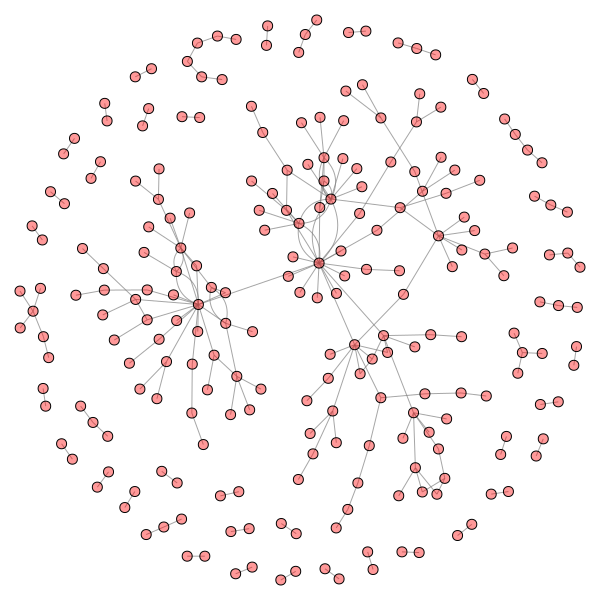

In [189]:
random.seed(123)
ig.plot(g,
        target='skipgrama.png',
        background=None,
        edge_color =adjustcolor('gray',0.7),
       
        vertex_label_cex=1,  # Tamaño del texto de las etiquetas de los vértices
        vertex_label_color=adjustcolor("black",0.6),  # Color del texto de las etiquetas de los vértices
        vertex_label_dist=0.5,
        vertex_size=10,
        vertex_label_degree=2
       )


In [190]:
# Agregar las métricas de centralidad al DataFrame ANIMES
df = df.assign(
    Closeness=g.closeness(),
    Betweenness=g.betweenness(directed=False),
    Eigenvector=g.eigenvector_centrality(directed=False)
)

df

,Identificador,token,Closeness,Betweenness,Eigenvector
0,0,ilegitimamente,0.159456,1.0,0.001142
1,1,mando,1.000000,0.0,0.000000
2,2,judicial,1.000000,0.0,0.000000
3,3,resultados,1.000000,0.0,0.000000
4,4,anexo,0.222031,0.0,0.030493
...,...,...,...,...,...
228,228,voluntarias,1.000000,0.0,0.000000
229,229,delincuencia,1.000000,0.0,0.000000
230,230,sali,0.211475,0.0,0.025378
231,231,acuerdo,0.168407,0.0,0.003869


In [193]:
# Calcular las medidas para el grafo
distancia_media = g.average_path_length()
grado_medio = sum(g.degree()) / len(g.vs)
grado_desviacion = np.std(g.degree())
numero_clan = len(g.largest_cliques()[0])
densidad = g.density()
transitividad = g.transitivity_undirected()
asortatividad = g.assortativity_degree()

# Imprimir los resultados
print("Distancia media:", distancia_media)
print("Grado medio:", grado_medio)
print("Grado desviación:", grado_desviacion)
print("Número clan:", numero_clan)
print("Densidad:", densidad)
print("Transitividad:", transitividad)
print("Asortatividad:", asortatividad)


Distancia media: 4.885245901639344
Grado medio: 1.854077253218884
Grado desviación: 2.177763772732463
Número clan: 3
Densidad: 0.007991712298357259
Transitividad: 0.040268456375838924
Asortatividad: 0.0644377858908607


In [194]:
random.seed(12)
eb=cg.community_edge_betweenness()
im=cg.community_infomap()
lp=cg.community_label_propagation()
le=cg.community_leading_eigenvector()

In [195]:
eb_clustering = eb.as_clustering()
print("Modularidad de community_edge_betweenness:", round(eb_clustering.modularity, 3))
print("Modularidad de community_infomap:", round(im.modularity, 3))
print("Modularidad de community_label_propagation:", round(lp.modularity, 3))
print("Modularidad de community_leading_eigenvector:", round(le.modularity, 3))

Modularidad de community_edge_betweenness: 0.738
Modularidad de community_infomap: 0.661
Modularidad de community_label_propagation: 0.683
Modularidad de community_leading_eigenvector: 0.709


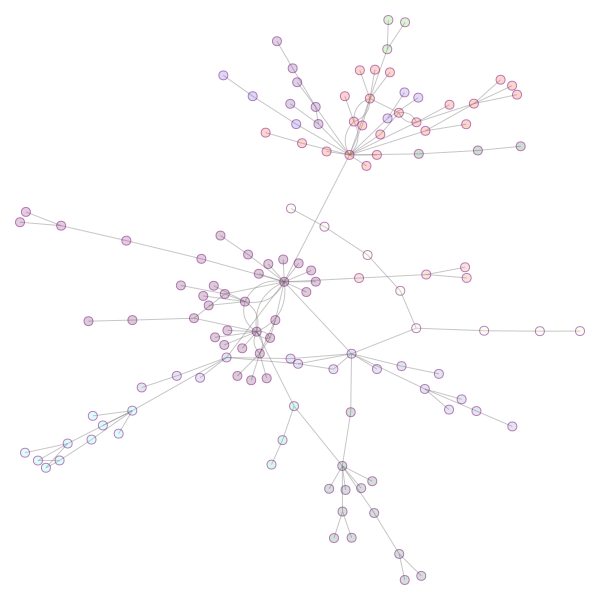

In [198]:
random.seed(3)
ig.plot(cg,
        target="skipcluster.png",
        edge_color =adjustcolor('gray',0.45),
        vertex_frame_color =adjustcolor('purple',0.5),
        vertex_color= get_colors_for_list(eb_clustering.membership, alpha=0.2),
        vertex_size = 9, #toca ajustar un tamaño minimo porque algunos son
        # pequeño
       )

In [199]:
Componente_Gigante=df.query('Identificador in @ g.connected_components()[0]')
Componente_Gigante['edge_betweenness']=eb.as_clustering().membership
Componente_Gigante['infomap']=im.membership
Componente_Gigante['label_propagation']=lp.membership
Componente_Gigante['leading_eigenvector']=le.membership

C:\Users\Pc\AppData\Local\Temp\ipykernel_4648\2612356879.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Pc\AppData\Local\Temp\ipykernel_4648\2612356879.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Pc\AppData\Local\Temp\ipykernel_4648\2612356879.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

In [200]:
Componente_Gigante

,Identificador,token,Closeness,Betweenness,Eigenvector,edge_betweenness,infomap,label_propagation,leading_eigenvector
0,0,ilegitimamente,0.159456,1.000000,0.001142,0,0,0,0
4,4,anexo,0.222031,0.000000,0.030493,1,1,1,1
5,5,grupo,0.176712,0.000000,0.004206,2,2,2,3
7,7,operacion,0.191395,0.000000,0.005429,1,1,1,8
9,9,comandante,0.302817,2160.483766,0.972514,3,3,3,13
...,...,...,...,...,...,...,...,...,...
225,225,sitio,0.196049,0.000000,0.009258,5,23,8,2
227,227,restaurativa,0.134096,0.000000,0.000158,8,16,13,4
230,230,sali,0.211475,0.000000,0.025378,3,20,1,14
231,231,acuerdo,0.168407,0.000000,0.003869,5,5,5,11


In [201]:
Componente_Gigante.query('edge_betweenness==0').sort_values(by=['Closeness','Betweenness','Eigenvector'],ascending=[False,False,False]).reset_index(drop=True)['token']
    

0           combate
1           muertes
2             bajas
3              baja
4            muerte
5           muertos
6       presentadas
7     legitimamente
8    ilegitimamente
9        ilegitimas
Name: token, dtype: object

In [202]:
set(eb.as_clustering().membership)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}

In [203]:
# Inicializar el diccionario
diccionario = {}

# Iterar sobre los clusters
for c in set(eb.as_clustering().membership):
    # Obtener los tokens ordenados según los criterios
    tokens_ordenados = Componente_Gigante.query('edge_betweenness==@c').sort_values(by=['Closeness','Betweenness','Eigenvector'],ascending=[False,False,False]).reset_index(drop=True)['token']
    
    # Concatenar los tokens en una cadena
    tema = ' '.join(tokens_ordenados)
    
    # Agregar al diccionario
    diccionario['cluster '+str(c)] = tema

# Mostrar el diccionario resultante
print(diccionario)

{'cluster 0': 'combate muertes bajas baja muerte muertos presentadas legitimamente ilegitimamente ilegitimas', 'cluster 1': 'operaciones inteligencia seccion oficial jefe orden desarrollo ordenes informacion anexo publico dia batalla operacion pago ministerio', 'cluster 2': 'jurisdiccion especial grupo paz', 'cluster 3': 'batallon comandante brigada comando comandantes trasladado guerrilla panza contraguerrilla magdalena contraguerrillas comante pigoanza compañia ejercito peloton division directamente abrigada ejecutivo movil cuarta novena operativo sali nacional b instruccion c nivel', 'cluster 4': 'coronel teniente torres pinto suarez escalante', 'cluster 5': 'señor gracias recuerdo dias magistrado preguntas hechos claro pregunta procurador compareciente doctor nombre dios muchisimas doctora exactamente honorable permiso sitio recuerda completo acuerdo', 'cluster 6': 'militares fuerzas unidades especiales tacticas grupos misiones armados', 'cluster 7': 'infanteria numero cedula ident

In [204]:
PromptInicio = ['Utilizando el diccionario de clusters  de palabras proporcionado a continuación, extrae el tema o tópico que más se relacione con cada cluster:Ten en cuenta que las palabras fueron obtenidas mediante un método de agrupamiento de una red asociada a bigramas sacados de un texto, también ten en cuenta que las palabras vienen de mayor a menor importancia' 
, '[Inicio  diccionario]']

PromptFinal = ['[Fin  diccionario]', 'Al momento de devolver los datos contesta con el siguiente formato: Numerodecluster:[dato] TemaoTopicoPrincipal:[dato] Solo contesta con el formato suministrado.' ]
request=" ".join(PromptInicio)+str(diccionario)+" ".join(PromptFinal)

In [205]:

    request = request
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": request,
            }
        ],
        model="gpt-4-1106-preview",
        max_tokens=2000,  # Incrementa el número de tokens permitidos
        temperature=0.7,  # Elimina la "creatividad" para obtener respuestas precisas
        top_p=1,  # Ajusta la probabilidad máxima para asegurar que la respuesta sea precisa
    )
    respuesta = chat_completion.choices[0].message.content

In [206]:
print(respuesta)

Cluster 0: Tema o Tópico Principal: Conflictos y bajas militares
Cluster 1: Tema o Tópico Principal: Operaciones militares y de inteligencia
Cluster 2: Tema o Tópico Principal: Jurisdicción y acuerdos de paz
Cluster 3: Tema o Tópico Principal: Estructura y movimientos militares
Cluster 4: Tema o Tópico Principal: Rangos y personal militar
Cluster 5: Tema o Tópico Principal: Procedimientos legales y judiciales
Cluster 6: Tema o Tópico Principal: Fuerzas y unidades militares
Cluster 7: Tema o Tópico Principal: Identificación militar
Cluster 8: Tema o Tópico Principal: Instituciones y vida militar
Cluster 9: Tema o Tópico Principal: Procesos voluntarios y diligencias
Cluster 10: Tema o Tópico Principal: Nombres propios
Cluster 11: Tema o Tópico Principal: Autoridades judiciales
Cluster 12: Tema o Tópico Principal: Altos mandos y liderazgo militar
Cluster 13: Tema o Tópico Principal: Estrategias y misiones tácticas
